# Modeling and ML

* machine learning workflow with `caret`:
    * training/testing splits
    * cross-validation
    * model fitting
* Extracting trained parameters with `broom`

In [2]:
# essentials
library(dplyr)
library(ggplot2)

inpatient <- readRDS("small_data/Medicare_Provider_Charge_Inpatient_DRGALL_FY2014_clean.RDS")
cardiac <- readRDS("small_data/inpatient_charges_2014_clean_cardiac_50plus.RDS")

# 1. Caret: machine learning in R

The caret package includes useful functions for creating machine learning pipelines (train/test splits, model fitting, and cross-validation).

## Caret: concepts

In [3]:
library(caret)

Loading required package: lattice


In [4]:
myvars <- c("Average.Total.Payments", "Provider.State", "Total.Discharges")
df <- cardiac %>% select_(.dots = myvars) %>% filter(Provider.State %in% c("DC", "MD", "VA"))

In [5]:
df %>% dim

[1] 1097    3

### Obtain train-test splits

In [6]:
## it uses Y to preserve class distributions
split <- createDataPartition(y=df$Average.Total.Payments,
                             p=0.80,
                             list=FALSE)

train <- df[split,]
test <- df[-split,]

In [7]:
?createDataPartition

In [8]:
train %>% dim

[1] 880   3

### Preprocessing data by scaling

In [9]:
# the pre-processing 'method'...
process <- preProcess(train, method = c("center", "scale"))
process

Created from 880 samples and 3 variables

Pre-processing:
  - centered (2)
  - ignored (1)
  - scaled (2)


In [10]:
# ... and the returned dataset
train_processed <- predict(process, train)
train_processed %>% head

Average.Total.Payments,Provider.State,Total.Discharges
3.225056,DC,2.2024801
4.863915,MD,-0.6229644
4.303953,MD,-0.1882806
2.725234,MD,-0.4056225
3.361615,MD,-0.7678590
2.886824,VA,0.5361923


In [11]:
# exercise: create a summary table showing that the pre-processing worked

### Create your own cross-valiation folds

In [12]:
folds  <- createFolds(y=df$Average.Total.Payments, k=5)

In [13]:
vignette("caret")

### Modeling with train(): notes

* Available models can be obtained with `names(getModelInfo())` and are listed here: http://topepo.github.io/caret/modelList.html.
* `train()` is like a lightweight Python scikit-learn pipeline
* "By default, the train function chooses the model with the largest performance value (or smallest, for mean squared error in regression models)."
* `train()` automatically resamples data into train/test splits, fits the model, and calculates average performance across hold-out predictions. This can be customized.

In [14]:
# create new data frame with dummy variables
df_dummies <- dummyVars(" ~ .", data=df, fullRank = TRUE) %>%
    predict(., newdata = df)

In [15]:
df_dummies %>% head

,Average.Total.Payments,Provider.StateMD,Provider.StateVA,Total.Discharges
1,75435.71,0,0,96
2,103678.78,1,0,18
3,94028.73,1,0,30
4,66822.08,1,0,24
5,77789.07,1,0,14
6,69606.82,0,1,50


In [16]:
split <- createDataPartition(y=df$Average.Total.Payments,
                             p=0.80,
                             list=FALSE)

train <- df_dummies[split,]
test <- df_dummies[-split,]

In [17]:
#install.packages('elasticnet')
library('elasticnet')
set.seed(1)
model <- train(Average.Total.Payments ~ ., data=train,
               method="ridge",
               tuneLength=10     # evaluate 10 parameter (lambda) values
              )

Loading required package: lars
Loaded lars 1.2



In [18]:
# note 2 predictors (excludes the categorical variable). see below for details
model

Ridge Regression 

880 samples
  3 predictors

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 880, 880, 880, 880, 880, 880, ... 
Resampling results across tuning parameters:

  lambda        RMSE      Rsquared  
  0.0000000000  16620.53  0.02758434
  0.0001000000  16620.51  0.02758521
  0.0002371374  16620.49  0.02758641
  0.0005623413  16620.43  0.02758923
  0.0013335214  16620.31  0.02759573
  0.0031622777  16620.05  0.02761028
  0.0074989421  16619.59  0.02764011
  0.0177827941  16619.22  0.02768872
  0.0421696503  16620.50  0.02771793
  0.1000000000  16626.66  0.02757271

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was lambda = 0.01778279. 

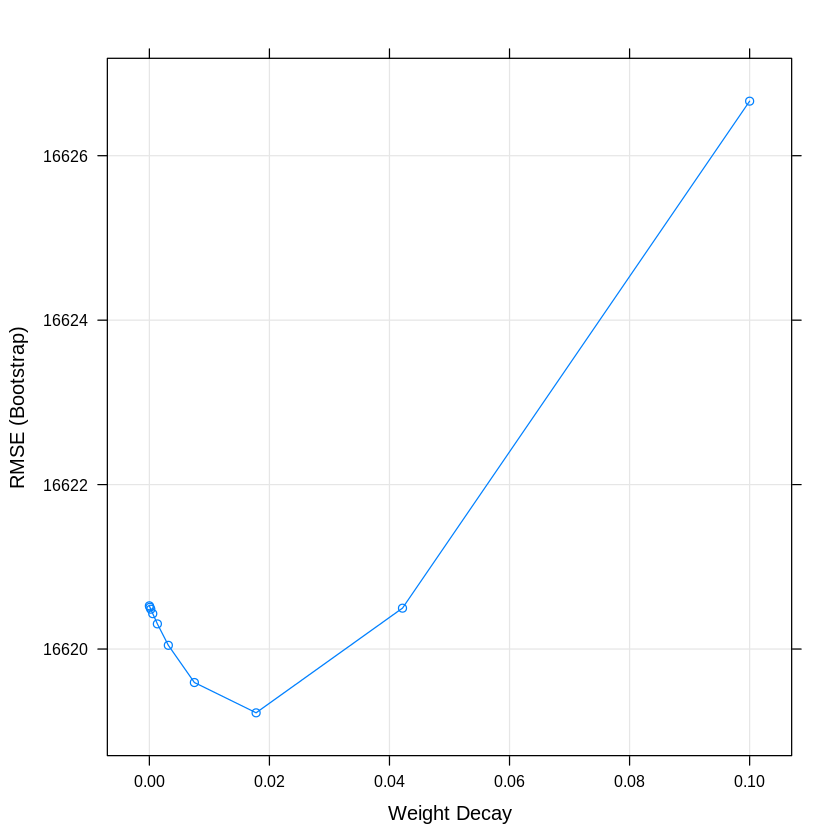

In [19]:
plot(model)

In [20]:
model$results

lambda,RMSE,Rsquared,RMSESD,RsquaredSD
0.0000000000,16620.53,0.02758434,1064.073,0.01538651
0.0001000000,16620.51,0.02758521,1064.068,0.01538661
0.0002371374,16620.49,0.02758641,1064.063,0.01538675
0.0005623413,16620.43,0.02758923,1064.049,0.01538708
0.0013335214,16620.31,0.02759573,1064.016,0.01538789
0.0031622777,16620.05,0.02761028,1063.942,0.01538990
0.0074989421,16619.59,0.02764011,1063.781,0.01539517
0.0177827941,16619.22,0.02768872,1063.451,0.01541053
0.0421696503,16620.50,0.02771793,1062.815,0.01545968
0.1000000000,16626.66,0.02757271,1061.512,0.01558504


### predict()

In [21]:
predict(model, newdata=head(test))

3        6       21       28       32       34 
22640.59 16604.40 20633.90 15646.66 16285.15 18337.44

### custom resampling with trainControl()

In [22]:
# passed to train() function below
# method="cv" does not repeat;
# other options: "boot", "LOOCV", ... See: https://topepo.github.io/caret/model-training-and-tuning.html#the-traincontrol-function
sampling  <- trainControl(method = "repeatedcv",
                          p = 0.75,
                          number=10,
                          repeats=10)

# now, pass this to train()...

### Metrics: evaluating model performace
Default metrics are:
* regression: RMSE and R-squared
* classification: accuracy and Kappa

In [23]:
set.seed(1)
model <- train(Average.Total.Payments ~ ., data=train,
               method="ridge",
               trControl = sampling,
               tuneLength = 5
               )

In [24]:
model$finalModel$lambda

[1] 0.01

In [25]:
model$results

lambda,RMSE,Rsquared,RMSESD,RsquaredSD
0e+00,16613.36,0.03783700,1655.462,0.03363797
1e-04,16613.34,0.03783690,1655.439,0.03363645
1e-03,16613.16,0.03783576,1655.229,0.03362321
1e-02,16612.01,0.03780755,1653.333,0.03352488
1e-01,16618.94,0.03702864,1643.693,0.03365344


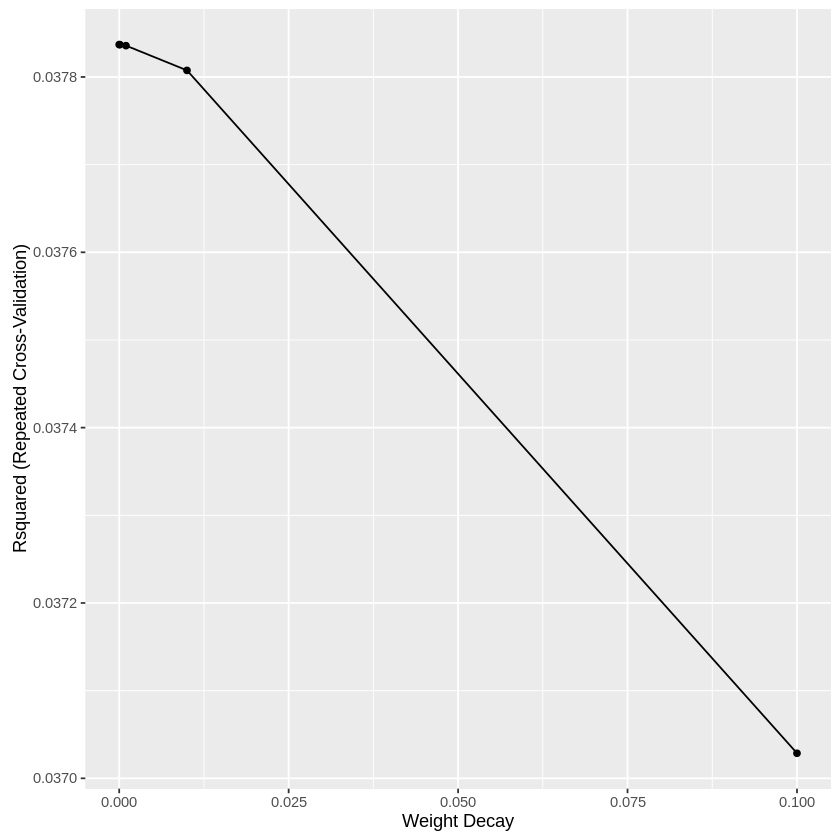

In [26]:
# can specify metric
#plot(model, metric="Rsquared")
 ggplot(model, metric="Rsquared")

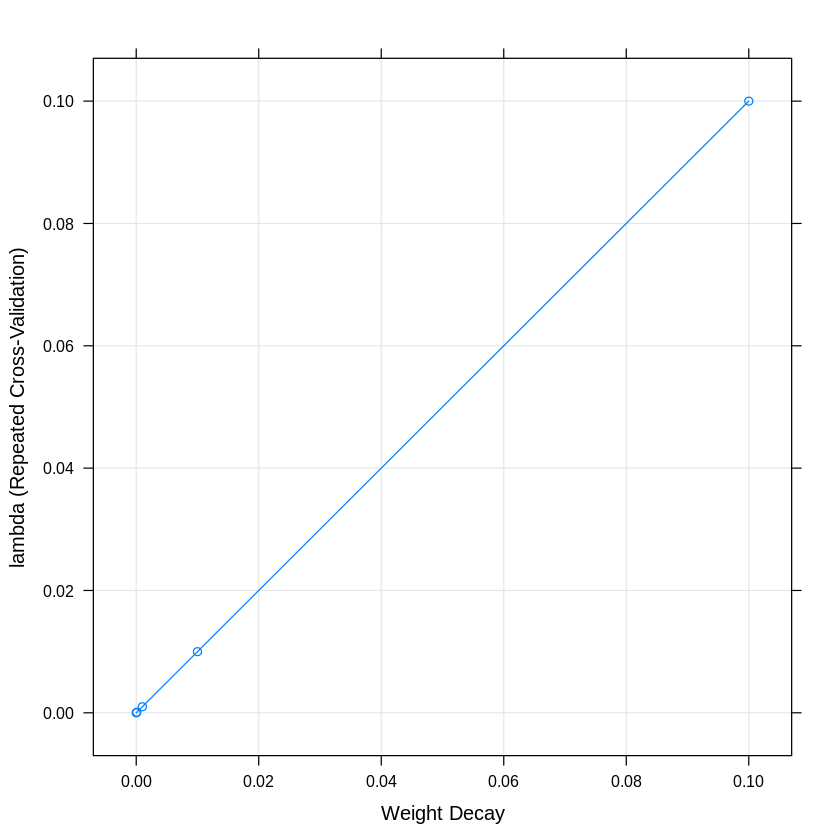

In [27]:
# and plot the lambda values
plot(model, metric="lambda")

In [28]:
getModelInfo

function (model = NULL, regex = TRUE, ...) 
{
    load(system.file("models", "models.RData", package = "caret"))
    if (!is.null(model)) {
        keepers <- if (regex) 
            grepl(model, names(models), ...)
        else which(model == names(models))[1]
        models <- models[keepers]
    }
    if (length(models) == 0) 
        stop("That model is not in caret's built-in library")
    models
}
<environment: namespace:caret>

### train() details
* You can pre-process features with PCA, with `train(... , preProcess="pca", k=2)`
* You can perform bootstrap resampling with createResample()
* You can perform time series splitting with createTimeSlices()
* "In cases where the model tuning values are known, train can be used to fit the model to the entire training set without any resampling or parameter tuning. Use `trainControl(..., method = "none")`

# 2. Broom: Tidying-up model results

## Broom: Motivation

In R, model inputs are often tidy. However, model outputs are messy and inconsistent.

This is especially burdensome when working with many models at once (eg,
running the same model on different subsets of data and comparing results).

For example, you need to extract p-values from a few regression models. Is this parameter called "pval" or "PValue"?"

The solution is broom:

        The broom package takes the messy output of built-in functions in R,
        such as lm, nls, or t.test, and turns them into tidy data frames.


## Broom: Introductory Examples

In [29]:
library(broom)

In [30]:
## You can tidy up lm output with tidy()
cardiac %>%
    group_by(DRG.code) %>%
    do(
        tidy(lm(Average.Total.Payments ~ Total.Discharges, data=.))
    ) %>%
    head()

DRG.code,term,estimate,std.error,statistic,p.value
216,(Intercept),68187.56385,1494.97268,45.611244,7.345751e-135
216,Total.Discharges,156.63305,42.74812,3.664092,2.947123e-04
217,(Intercept),43953.47554,1251.78061,35.112763,3.046815e-67
217,Total.Discharges,124.36103,37.66967,3.301357,1.249531e-03
219,(Intercept),55679.20035,781.41717,71.254130,2.075788e-256
219,Total.Discharges,69.15956,13.95518,4.955833,1.002196e-06


In [31]:
## You can review model fit with glance()
cardiac %>%
    group_by(DRG.code) %>%
    do(
        glance(lm(Average.Total.Payments ~ Total.Discharges, data=.))
    ) %>%
    arrange(desc(adj.r.squared)) %>%
    head()

DRG.code,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
217,0.07903581,0.07178413,9592.548,10.89896,1.249531e-03,2,-1364.803,2735.606,2744.185,11686155087,127
237,0.06516683,0.06372196,10649.373,45.10210,4.098939e-11,2,-6938.233,13882.466,13895.892,73375712827,647
219,0.04896776,0.04697398,12164.456,24.56028,1.002196e-06,2,-5184.274,10374.549,10387.064,70583592644,477
216,0.04395694,0.04068282,17668.665,13.42557,2.947123e-04,2,-3291.352,6588.703,6599.754,91157062366,292
220,0.03610941,0.03431779,8394.474,20.15463,8.743602e-06,2,-5644.303,11294.605,11307.480,37911354195,538
251,0.02607545,0.02445763,3894.000,16.11770,6.704277e-05,2,-5849.421,11704.843,11718.053,9128267143,602


## Broom: Concepts
Let's learn to tidy up our model output with broom!

**3 little functions that do a lot:**

    tidy()             #tidy up model output
    glance()           #obtain one-row summary of model fit (R^2, AIC...)
    augment()          #augment model output with more info (residuals, predictions, ...) 
    
The output differs slightly depending on what model you run, but it strives for consistency. A p-value is always `p.value`.

In [32]:
## prepare data
myvars <- c("Provider.Id", "DRG.code", "Average.Medicare.Payments",
            "Average.Covered.Charges", "Average.Total.Payments",
            "Total.Discharges", "Provider.State")
df <- cardiac %>% select_(.dots=myvars)

In [33]:
## standard lm
lm(Average.Total.Payments ~ Total.Discharges, data=df)


Call:
lm(formula = Average.Total.Payments ~ Total.Discharges, data = df)

Coefficients:
     (Intercept)  Total.Discharges  
        19900.31            -40.01  


In [34]:
## lm summary()
lm(Average.Total.Payments ~ Total.Discharges, data=df) %>% summary


Call:
lm(formula = Average.Total.Payments ~ Total.Discharges, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-16820 -11251  -4833   5727 277596 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      19900.31     161.07  123.55   <2e-16 ***
Total.Discharges   -40.01       3.89  -10.29   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15680 on 22394 degrees of freedom
Multiple R-squared:  0.004702,	Adjusted R-squared:  0.004657 
F-statistic: 105.8 on 1 and 22394 DF,  p-value: < 2.2e-16


In [35]:
## tidy() results
lm(Average.Total.Payments ~ Total.Discharges, data=df) %>% tidy

term,estimate,std.error,statistic,p.value
(Intercept),19900.31277,161.069818,123.55085,0.000000e+00
Total.Discharges,-40.00608,3.889629,-10.28532,9.317356e-25


In [36]:
## use glance() to see fit statistics (1 row/model)
lm(Average.Total.Payments ~ Total.Discharges, data=df) %>% summary %>% glance

r.squared,adj.r.squared,sigma,statistic,p.value,df
0.004701723,0.004657278,15683.22,105.7878,9.317356e-25,2


In [37]:
## augment() results to see predictions, clusters, etc
lm(Average.Total.Payments ~ Total.Discharges, data=df) %>% augment %>% head

Average.Total.Payments,Total.Discharges,.fitted,.se.fit,.resid,.hat,.sigma,.cooksd,.std.resid
49868.00,11,19460.25,131.5575,30407.75,7.036571e-05,15682.25,1.322789e-04,1.938941
59623.00,21,19060.19,112.3989,40562.81,5.136340e-05,15681.22,1.718123e-04,2.586450
56985.50,16,19260.22,120.7982,37725.28,5.932680e-05,15681.54,1.716593e-04,2.405527
46413.43,14,19340.23,124.8499,27073.20,6.337331e-05,15682.52,9.443661e-05,1.726308
43955.62,13,19380.23,127.0061,24575.38,6.558109e-05,15682.71,8.052596e-05,1.567038
43870.05,22,19020.18,111.0520,24849.87,5.013977e-05,15682.69,6.294683e-05,1.584528


### do() from dplyr is a helper for broom
Recall that usually, dplyr returns a single value. We use `do()` when we aim to return something else.

Broom cleans up model outputs which return more than just a single value.

This is most useful when working with multiple models:

In [38]:
df %>%
    group_by(DRG.code) %>%
    do(
        tidy(lm(Average.Total.Payments ~ Total.Discharges, data=.))
    ) %>%
    head

DRG.code,term,estimate,std.error,statistic,p.value
216,(Intercept),68187.56385,1494.97268,45.611244,7.345751e-135
216,Total.Discharges,156.63305,42.74812,3.664092,2.947123e-04
217,(Intercept),43953.47554,1251.78061,35.112763,3.046815e-67
217,Total.Discharges,124.36103,37.66967,3.301357,1.249531e-03
219,(Intercept),55679.20035,781.41717,71.254130,2.075788e-256
219,Total.Discharges,69.15956,13.95518,4.955833,1.002196e-06


In [39]:
## rewrite it a bit. note placement of %>%
df %>%
    group_by(DRG.code) %>%
    do(
        lm(Average.Total.Payments ~ Total.Discharges, data=.)
        %>%  tidy
    ) %>%
    head

DRG.code,term,estimate,std.error,statistic,p.value
216,(Intercept),68187.56385,1494.97268,45.611244,7.345751e-135
216,Total.Discharges,156.63305,42.74812,3.664092,2.947123e-04
217,(Intercept),43953.47554,1251.78061,35.112763,3.046815e-67
217,Total.Discharges,124.36103,37.66967,3.301357,1.249531e-03
219,(Intercept),55679.20035,781.41717,71.254130,2.075788e-256
219,Total.Discharges,69.15956,13.95518,4.955833,1.002196e-06


In [40]:
## augment it with more info
df %>%
    group_by(DRG.code) %>%
    do(
        lm(Average.Total.Payments ~ Total.Discharges, data=.)
        %>% augment %>% tidy
    ) %>%
    head

DRG.code,column,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
216,Average.Total.Payments,294,7.215613e+04,1.803942e+04,6.796518e+04,7.037099e+04,1.534216e+04,4.333483e+04,1.534943e+05,1.101594e+05,1.175690,1.861853,1.052080e+03
216,Total.Discharges,294,2.533673e+01,2.414643e+01,1.750000e+01,2.047458e+01,8.154300e+00,1.100000e+01,2.750000e+02,2.640000e+02,5.229510,41.555347,1.408248e+00
216,.fitted,294,7.215613e+04,3.782129e+03,7.092864e+04,7.139456e+04,1.277233e+03,6.991053e+04,1.112617e+05,4.135113e+04,5.229510,41.555347,2.205782e+02
216,.se.fit,294,1.262349e+03,7.293624e+02,1.121203e+03,1.127253e+03,8.832183e+01,1.030558e+03,1.072227e+04,9.691708e+03,8.848175,99.545035,4.253728e+01
216,.resid,294,4.170451e-13,1.763849e+04,-4.326200e+03,-1.950967e+03,1.449569e+04,-2.776345e+04,8.295721e+04,1.107207e+05,1.334125,2.464734,1.028698e+03
216,.hat,294,6.802721e-03,2.256456e-02,4.026812e-03,4.082197e-03,6.326535e-04,3.402024e-03,3.682694e-01,3.648674e-01,14.279242,221.964545,1.315992e-03


Of course, you can use other models: `glm()`, correlations, wilcoxon, and other hypothesis tests.

In [41]:
## example: correlations
df %>%
    group_by(DRG.code) %>%
    do(
        cor.test(.$Average.Total.Payments, .$Average.Medicare.Payments) %>% tidy 
    )  %>%
    head

DRG.code,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
216,0.9352894,45.16239,9.225727e-134,292,0.9192473,0.9482306,Pearson's product-moment correlation,two.sided
217,0.9085970,24.51522,5.450751e-50,127,0.8728239,0.9346586,Pearson's product-moment correlation,two.sided
219,0.9208468,51.57816,3.132612e-197,477,0.9059999,0.9334305,Pearson's product-moment correlation,two.sided
220,0.8856615,44.24160,2.199678e-181,538,0.8660001,0.9025887,Pearson's product-moment correlation,two.sided
221,0.8854031,21.46616,4.433635e-44,127,0.8413073,0.9177931,Pearson's product-moment correlation,two.sided
226,0.8658425,14.98734,2.931131e-24,75,0.7962881,0.9128014,Pearson's product-moment correlation,two.sided


### Streamline your workflow by saving models into data frame

In [42]:
# assign lm output to new variable `fit`
regressions <- df %>% group_by(DRG.code) %>%
    do(fit = lm(Average.Medicare.Payments ~ Total.Discharges, .))

In [43]:
# ugly output in jupyter. models are saved inside data frame celss
# regressions[1,]

In [44]:
# tidy it up:
regressions %>% tidy(fit) %>% head

DRG.code,term,estimate,std.error,statistic,p.value
216,(Intercept),63393.24806,1325.74302,47.817146,3.815798e-140
216,Total.Discharges,111.79943,37.90907,2.949148,3.444175e-03
217,(Intercept),40006.31913,1126.27338,35.520967,8.031475e-68
217,Total.Discharges,102.29156,33.89280,3.018091,3.074579e-03
219,(Intercept),51946.88314,700.17204,74.191599,4.362062e-264
219,Total.Discharges,50.97673,12.50424,4.076755,5.349974e-05


### Broom Application: visualize p-values

In [45]:
df2 <- df %>% filter(Provider.State %in% c("DC", "MD", "VA"))

In [46]:
result <- df2 %>%
    group_by(DRG.code) %>%
    do(
        fit=lm(Average.Total.Payments ~ Total.Discharges + factor(Provider.State), data=.)
    )

In [47]:
#result %>% head

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


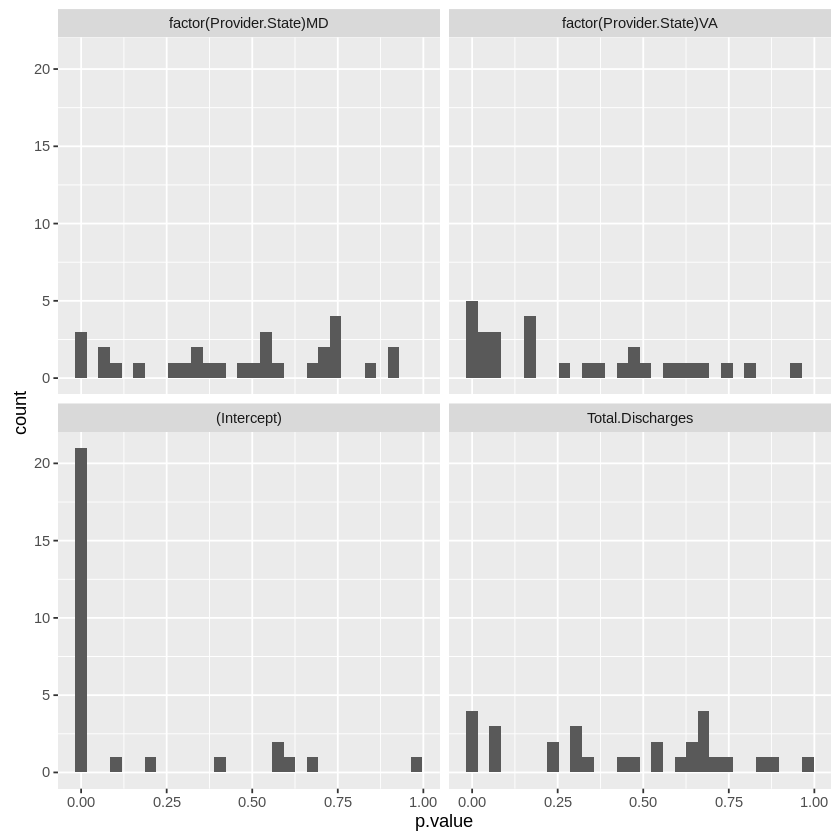

In [48]:
# We can explore the distribution of p-values
result %>% tidy(fit) %>% qplot(p.value, data=.) + facet_wrap(~term)#~term gives four panels

In [49]:
## Which DRG codes give the smallest p-value?
result %>% tidy(fit) %>% filter(term=="Total.Discharges") %>% arrange(p.value) %>% head

DRG.code,term,estimate,std.error,statistic,p.value
237,Total.Discharges,481.18414,98.51047,4.884599,4.153115e-05
219,Total.Discharges,208.01169,54.83342,3.793520,1.594382e-03
251,Total.Discharges,115.29418,36.68274,3.143009,4.557658e-03
220,Total.Discharges,99.19749,35.50398,2.793982,1.087536e-02
280,Total.Discharges,39.57979,21.01791,1.883146,6.277250e-02
236,Total.Discharges,74.79415,38.66856,1.934237,6.547991e-02


In [50]:
## we can sort by a fit statistic
## Question: what is the "statistic" here?
result %>% glance(fit) %>% arrange(desc(adj.r.squared)) %>% head

DRG.code,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
220,0.6925385,0.6486154,6713.384,15.767077,1.343611e-05,4,-253.5905,517.1810,523.2754,946460141,21
251,0.6068032,0.5555166,3412.545,11.831626,6.870256e-05,4,-255.7975,521.5950,528.0741,267845656,23
244,0.5809700,0.5460508,2933.228,16.637567,6.018540e-07,4,-374.0047,758.0094,766.4538,309737755,36
219,0.6158028,0.5437658,8409.516,8.548425,1.285525e-03,4,-206.8897,423.7794,428.7581,1131519475,16
234,0.5441843,0.4790677,6335.724,8.357083,7.556327e-04,4,-252.1430,514.2861,520.3804,842969339,21
236,0.5362059,0.4757110,5364.728,8.863657,4.348276e-04,4,-268.0119,546.0239,552.5031,661947090,23


In [51]:
## you can easily filter the tidy output
result %>% filter(DRG.code==220) %>% tidy(fit) %>% head

DRG.code,term,estimate,std.error,statistic,p.value
220,(Intercept),38402.10029,5146.62951,7.461602,2.469971e-07
220,Total.Discharges,99.19749,35.50398,2.793982,1.087536e-02
220,factor(Provider.State)MD,8597.68746,5252.41564,1.636902,1.165505e-01
220,factor(Provider.State)VA,-7535.51870,5095.10376,-1.478973,1.539923e-01


## Broom: Summary

Use `broom`, along with `dplyr`, to improve your modeling workflow by saving model result in a dataframe. Here are the three helper functions:

    tidy()             #tidy up model output
    glance()           #return summary of model fit
    augment()          #augment model output with more info (residuals, predictions) ( before tidy() )

In summary, with this workflow:

        A new class of analyses and visualizations becomes straightforward. This includes

        * Sorting by p-value or estimate to find the most significant terms across all tests
        * P-value histograms
        * Volcano plots comparing p-values to effect size estimates

        In each of these cases, we can easily filter, facet, or distinguish
        based on the term column. In short, this makes the tools of tidy data
        analysis available for the results of data analysis and models, not
        just the inputs.
        
(from the `broom` vignette)

## Broom: Exercises

1. Subset `cardiac` to provider "360006", then summarize a linear regression for each DRG Code.

2. For each Provider, return top DRG.codes which provide best model fit, using a regression of
Average.Total.Payment onto Provider.State and Total.Discharges.

3. Create a target y: 0/1, where 1 means Average.Total.Payments is greater than or equal to its mean across each DRG.code, and 0 otherwise. Run a logistic regression, and return model fit summaries.

In [52]:
#fun(x,y)={if x>y then 1 else 0}
per_code_avg <- cardiac %>% group_by(DRG.code) %>% summarise(avg=mean(Average.Total.Payments)) 
out<-left_join(cardiac,per_code_avg,"DRG.code")%>% mutate (.,y=ifelse(Average.Total.Payments>avg,1,0)) 
out %>% select(y)%>%head
#lapply(out[,"y"], as.numeric) %>% head

y
0
0
0
0
0
0


In [55]:
#as.numeric(out$y) #%>% head
fit<-glm(data=out,y~Provider.State + Total.Discharges,family='binomial') 

In [59]:
pred<-predict(fit,out, type = "response")

In [60]:
pred %>% head

1          2          3          4          5          6 
0.03134721 0.03332345 0.03232073 0.03192786 0.03173316 0.03352757

In [69]:
(t <- table(out$y, round(pred)))

   
        0     1
  0 12551  1521
  1  3887  4437

In [67]:
?table

In [76]:
cardiac %>% names

[1] "DRG.Definition"                            
 [2] "DRG.code"                                  
 [3] "DRG.text"                                  
 [4] "Provider.Id"                               
 [5] "Provider.Name"                             
 [6] "Provider.Street.Address"                   
 [7] "Provider.City"                             
 [8] "Provider.State"                            
 [9] "Provider.Zip.Code"                         
[10] "Hospital.Referral.Region..HRR..Description"
[11] "Total.Discharges"                          
[12] "Average.Covered.Charges"                   
[13] "Average.Total.Payments"                    
[14] "Average.Medicare.Payments"

In [86]:
cardiac %>% filter(Provider.Id=="360006")%>%group_by(DRG.code) %>%
    do(lm(Average.Medicare.Payments ~ Total.Discharges, .) %>% tidy ) 

DRG.code,term,estimate,std.error,statistic,p.value
216,(Intercept),62004.267,NaN,NaN,NaN
219,(Intercept),45223.698,NaN,NaN,NaN
220,(Intercept),29569.301,NaN,NaN,NaN
227,(Intercept),33384.955,NaN,NaN,NaN
233,(Intercept),40696.850,NaN,NaN,NaN
234,(Intercept),25700.556,NaN,NaN,NaN
235,(Intercept),34820.308,NaN,NaN,NaN
236,(Intercept),22968.493,NaN,NaN,NaN
237,(Intercept),32298.878,NaN,NaN,NaN
238,(Intercept),19794.181,NaN,NaN,NaN


In [95]:
cardiac %>% group_by(DRG.code) %>%    
    do(lm(Average.Medicare.Payments ~ Total.Discharges + Provider.State, .) %>% 
    glance )%>% arrange(desc(r.squared)) %>% select(DRG.code) %>% head

DRG.code
217
221
244
226
233
248


## Broom: Details

If time allows, review this KMeans clustering vignette(): [https://cran.r-project.org/web/packages/broom/vignettes/kmeans.html](https://cran.r-project.org/web/packages/broom/vignettes/kmeans.html)

See the `broom` conventions at the bottom of this link:  
[https://cran.r-project.org/web/packages/broom/vignettes/broom.html](https://cran.r-project.org/web/packages/broom/vignettes/broom.html)

# 3. Elegant pipelines with purrr and modelr

* [`modelr` is a new package that provides helpers for modeling](https://github.com/hadley/modelr). It is actively being developed.
* [`purrr` is for functional programming with R](https://github.com/hadley/purrr)

In [66]:
library(modelr)
library(purrr)


Attaching package: ‘modelr’

The following object is masked from ‘package:broom’:

    bootstrap


Attaching package: ‘purrr’

The following object is masked from ‘package:caret’:

    lift

The following objects are masked from ‘package:dplyr’:

    contains, order_by



## Examples

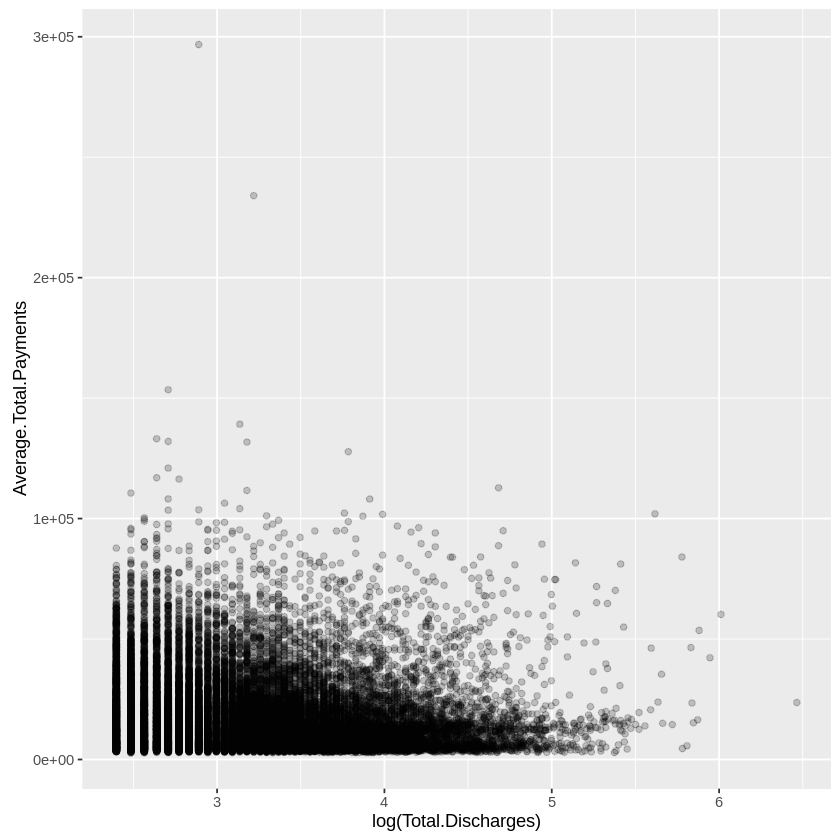

In [67]:
cardiac %>%
    ggplot(aes(log(Total.Discharges), Average.Total.Payments)) +
    geom_point(alpha=0.2) 

In [68]:
DRG249  <- cardiac %>%
    filter(DRG.code==249) %>%
    transmute(covered_scaled=scale(Average.Covered.Charges,
                                   center = TRUE, scale=TRUE),
              total_scaled=scale(Average.Total.Payments,
                                 center=TRUE, scale=TRUE))
    
DRG249 %>% head

covered_scaled,total_scaled
-0.1466292,-0.3419701
-0.1318192,-0.4185388
0.2970405,-0.3034071
1.2850413,-0.2866476
-0.4275265,-0.3004675
2.2724722,-0.4489771


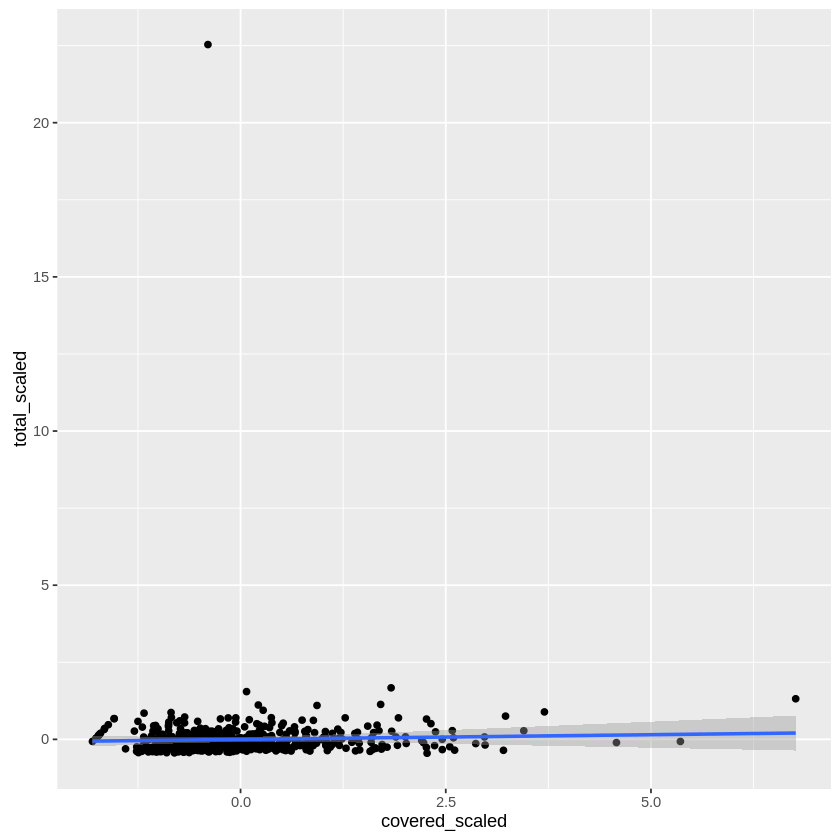

In [69]:
DRG249 %>%
    ggplot(aes(x=covered_scaled, y=total_scaled)) +
    geom_point() +
    geom_smooth(method="lm")

In [70]:
DRG249_mod <- lm(total_scaled ~ covered_scaled, data=DRG249)

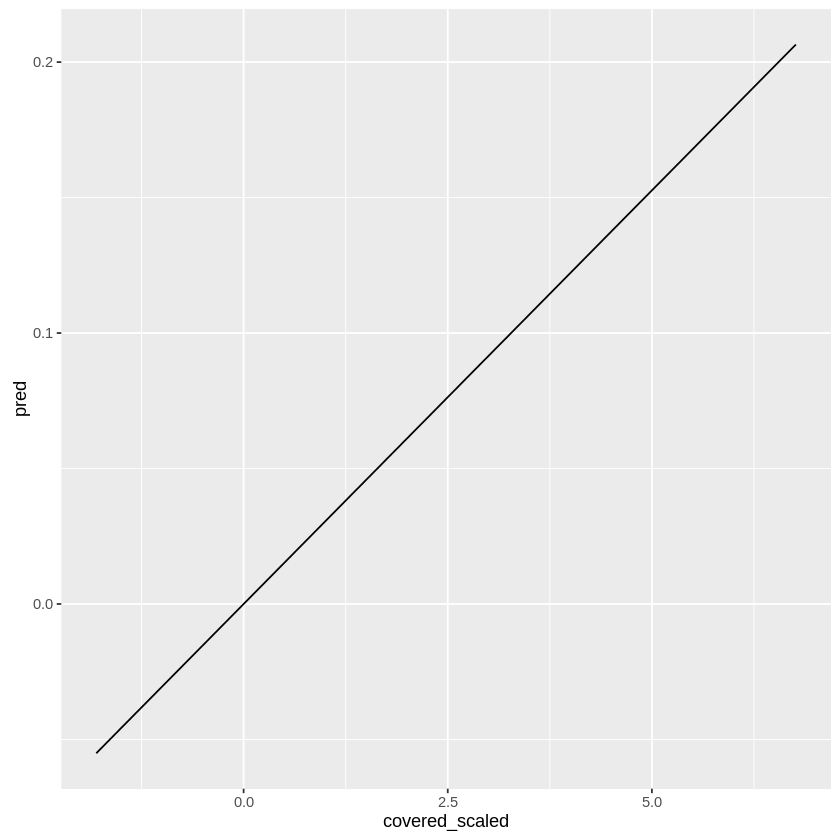

In [71]:
# extract linear trend with add_predictions()...
DRG249 %>%
    add_predictions(DRG249_mod) %>%
    ggplot(aes(covered_scaled, pred)) +
    geom_line()

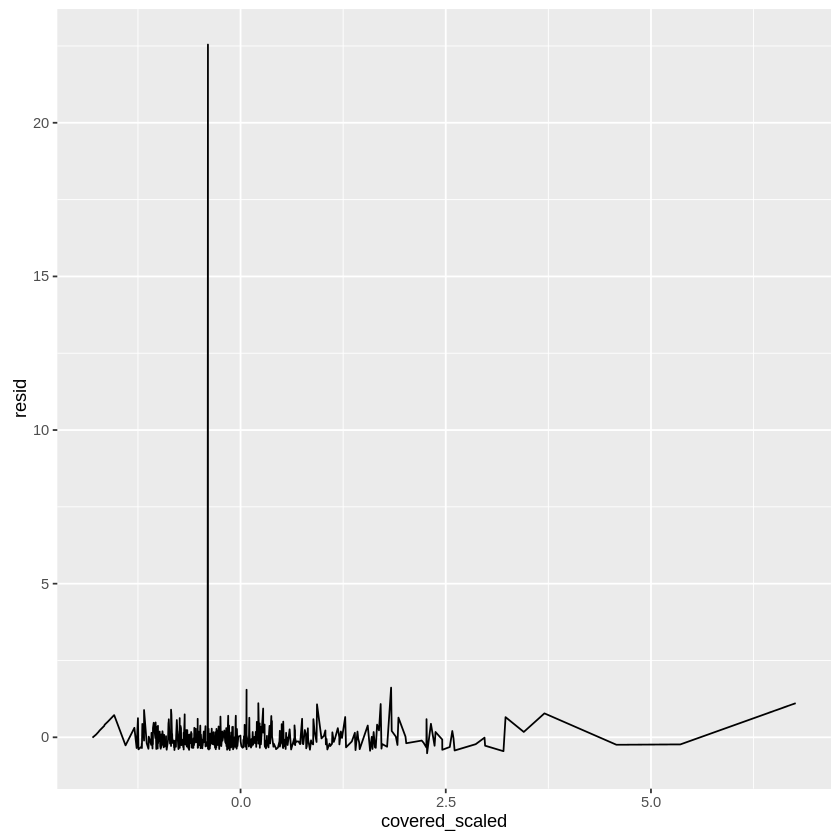

In [72]:
# ... and the residuals with add_residuals()
DRG249 %>%
    add_residuals(DRG249_mod) %>%
    ggplot(aes(covered_scaled, resid)) +
    geom_line()

## It's not usually this revealing!

*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*